In [172]:
import os
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

import warnings

from pmdarima import auto_arima

In [3]:
plt.rcParams["figure.figsize"] = (15, 5)
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)

PATH_TGE='../../data/tge/'

# Read data

In [4]:
df_tge=pd.read_parquet(f'{PATH_TGE}tge_full.parquet')
df_tge.head(3)

,date,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,date_hour
date_hour,,,,,,,,,
2019-06-28 00:00:00,2019-06-28,1,220.54,1754.3,226.53,1245.7,0.0,5.0,2019-06-28 00:00:00
2019-06-28 01:00:00,2019-06-28,2,203.85,1674.0,191.84,1277.3,0.0,0.0,2019-06-28 01:00:00
2019-06-28 02:00:00,2019-06-28,3,203.85,1786.2,201.12,1079.6,0.0,0.0,2019-06-28 02:00:00


# EDA

In [5]:
def draw_simple_plot():
    plt.style.use('seaborn-v0_8')
    fig = df_tge['fixing_1_kurs'].plot(figsize=(15, 8));
    fig.set_title("Fixing kurs of energy")
    fig.set_xlabel("Date-Hour")
    fig.set_ylabel("PLN");   

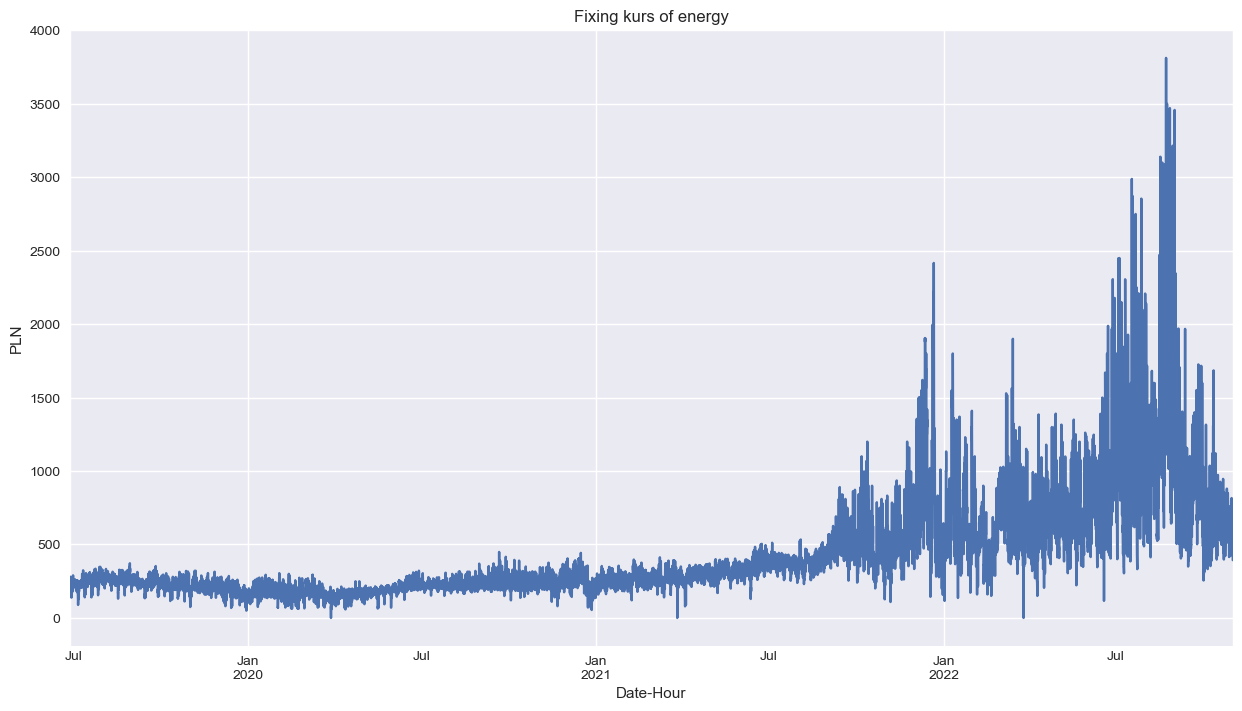

In [6]:
draw_simple_plot()

In [81]:
df_tge.query('fixing_1_kurs<5')

,date,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,date_hour
date_hour,,,,,,,,,
2020-03-28 01:00:00,2020-03-28,2,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-28 01:00:00
2021-03-27 01:00:00,2021-03-27,2,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-27 01:00:00
2022-03-26 01:00:00,2022-03-26,2,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-26 01:00:00


In [82]:
df_tge['fixing_1_kurs']=df_tge['fixing_1_kurs'].replace(0, np.nan).fillna(method='backfill')

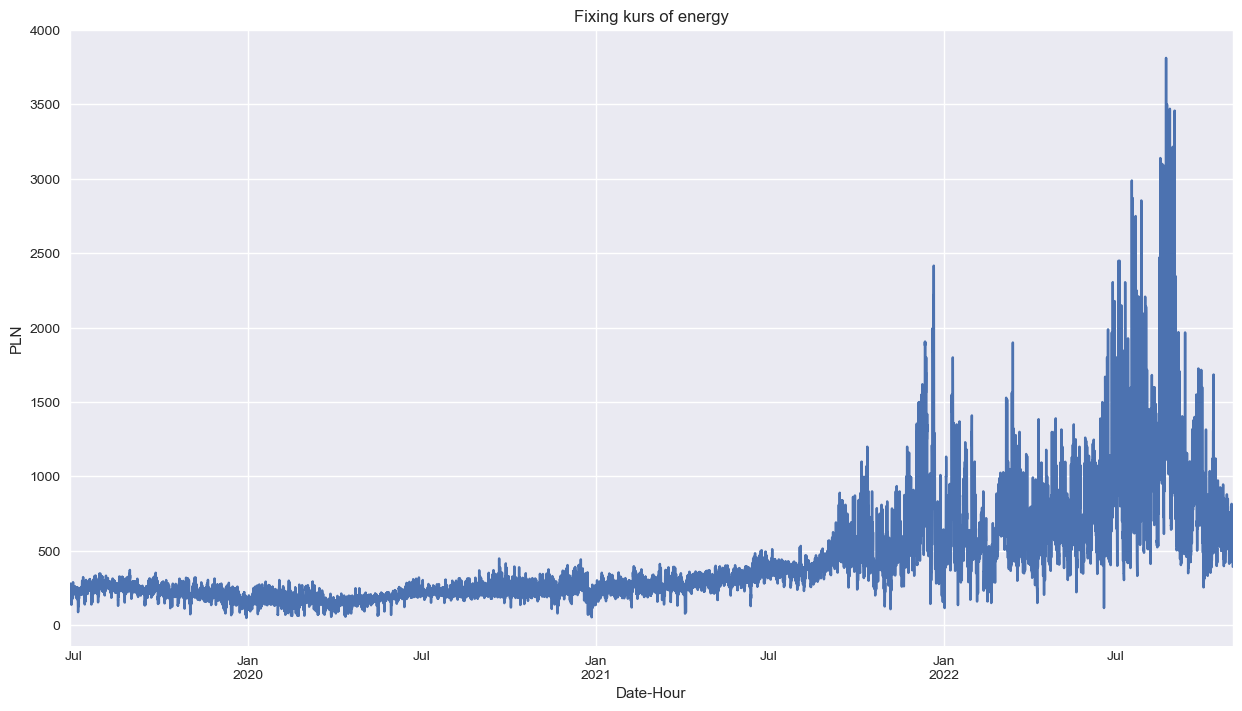

In [83]:
draw_simple_plot()

## Correlogram

Autocorrelation is very strong and positive

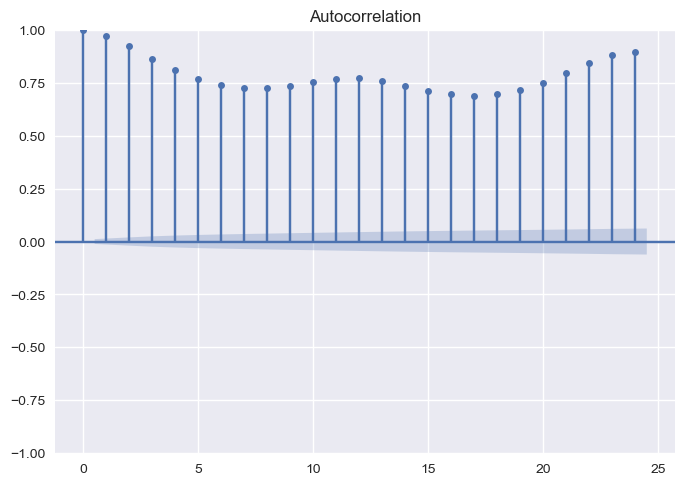

In [19]:
sm.graphics.tsa.plot_acf(df_tge['fixing_1_kurs'], lags=24, alpha=0.05, title="Autocorrelation");

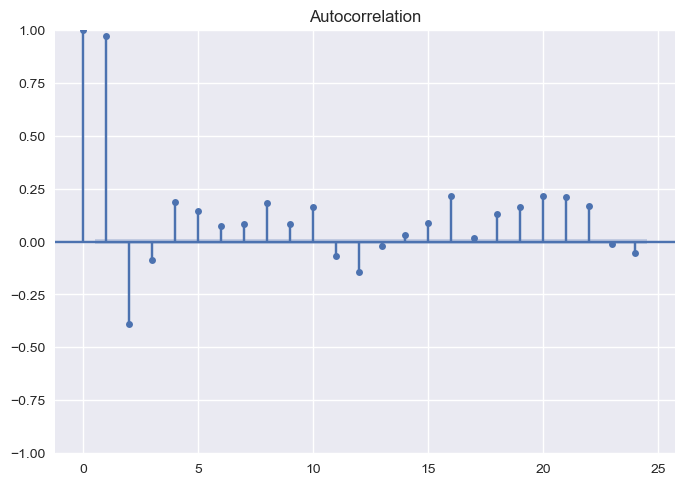

In [20]:
warnings.filterwarnings("ignore")
sm.graphics.tsa.plot_pacf(df_tge['fixing_1_kurs'], lags=24, alpha=0.05, title="Autocorrelation");

In [21]:
sm.tsa.stattools.acf(df_tge['fixing_1_kurs'], nlags=24, fft=True)

array([1.        , 0.97161143, 0.92213128, 0.86216048, 0.80788387,
       0.76642536, 0.73907591, 0.72477565, 0.72478595, 0.73408751,
       0.75270214, 0.76830342, 0.77107828, 0.75908413, 0.73569008,
       0.71003109, 0.6949837 , 0.68908272, 0.6968662 , 0.71666298,
       0.74959837, 0.79382963, 0.84189751, 0.87899475, 0.89546822])

In [22]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
check_stationarity(df_tge['fixing_1_kurs'])

The series is stationary


# SARIMAX

In [12]:
def get_df(df_tge,train_start_date,train_end_date,forecast_end_date):
    data=pd.DataFrame(df_tge.query('date_hour>@train_start_date')['fixing_1_kurs'])
    train = data[data.index <= train_end_date]
    forecast = data[(data.index > train_end_date) & (data.index <= forecast_end_date)]
    return data, train, forecast

In [13]:
def get_decompose_data(data):
    decompose_data = seasonal_decompose(data, model="additive")
    decompose_data.plot();
    return decompose_data

def get_seasonality(decompose_data):
    seasonality=decompose_data.seasonal
    seasonality.plot(color='green');
    return seasonality

In [14]:
def create_model_sarimax(train,order,seasonal_order,chart=True):
    mod = sm.tsa.statespace.SARIMAX(train,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    if chart:
        results.plot_diagnostics(figsize=(16, 8))
        plt.show()
    return results

In [64]:
def scoring(y_pred,y_test):
    mae_f=round(mean_absolute_error(y_test, y_pred),4)
    rmse_f=round(rmse(y_pred, y_test),4)
    nrmse_f = round(rmse(y_pred, y_test)/(np.max(y_test)-np.min(y_test)),4)
    return mae_f, rmse_f, nrmse_f

In [159]:
def get_forecast(results,data,forecast,train_start_test,forecast_end_date,train_end_date,chart=True):
    pred = results.get_prediction(start=train_start_test, dynamic=False)
    pred_ci = pred.conf_int()
    # Variant 2
    #start_forecast = 647
    #pred = results.get_prediction(start=start_forecast, dynamic=False)
    
    pred_for = results.get_forecast(forecast_end_date)
    pred_for_ci = pred_for.conf_int()
    
    if chart:
        ax = data.plot(label='train')
        pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7)
        pred_for.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
        ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
        ax.set_xlabel('Date')
        ax.set_ylabel('PLN')
        plt.legend()
        plt.show()
   
    mae_test, rmse_test, nrmse_test = scoring(pred.predicted_mean[train_start_test:train_end_date].values, train[-len(pred_ci):]['fixing_1_kurs'])
    mae_forecast, rmse_forecast, nrmse_forecast = scoring(pred_for.predicted_mean.values, forecast['fixing_1_kurs'])
    print(f"Test_range. mae: {mae_test}, rmse: {rmse_test}, nrmse: {nrmse_test}")
    print(f"Forecast.   mae: {mae_forecast}, rmse: {rmse_forecast}, nrmse: {nrmse_forecast}")
    metrics={
        "mae_test": mae_test,
        "rmse_test": rmse_test,
        "nrmse_test": nrmse_test,
        "mae_forecast": mae_forecast,
        "rmse_forecast": rmse_forecast,
        "nrmse_forecast": nrmse_forecast        
    }
    df_kurs=pd.concat([pd.DataFrame(forecast['fixing_1_kurs']).rename(columns={'fixing_1_kurs':'kurs_fact'}).reset_index(),
                       pd.DataFrame(pred_for.predicted_mean.values,columns=['kurs_predict'])],axis=1)
    df_kurs['diff_perc']=round(df_kurs['kurs_predict']/df_kurs['kurs_fact']*100-100,2)
    return metrics, df_kurs

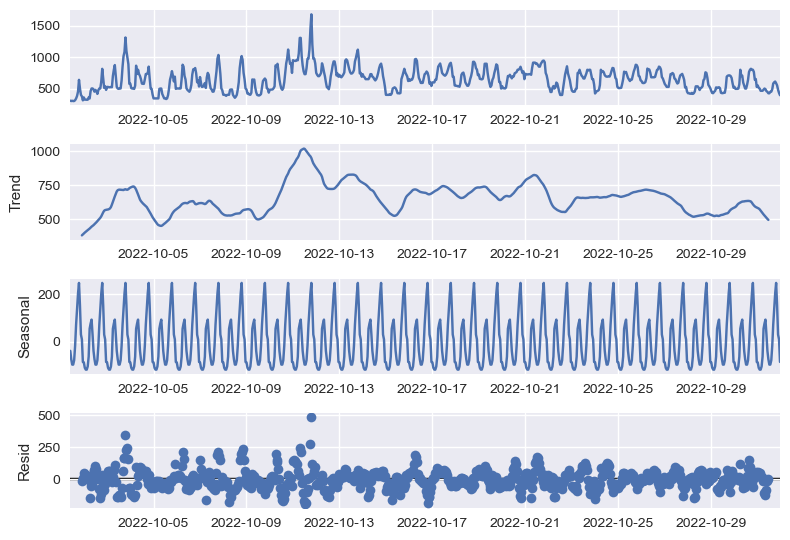

In [174]:
train_start_date="2022-10-01 09:00:00"  
train_end_date="2022-10-28 09:00:00"
train_start_test="2022-10-26 09:00:00"
forecast_end_date="2022-10-30 00:00:00"
data, train, forecast = get_df(df_tge,train_start_date,train_end_date,forecast_end_date)
decompose_data=get_decompose_data(data)

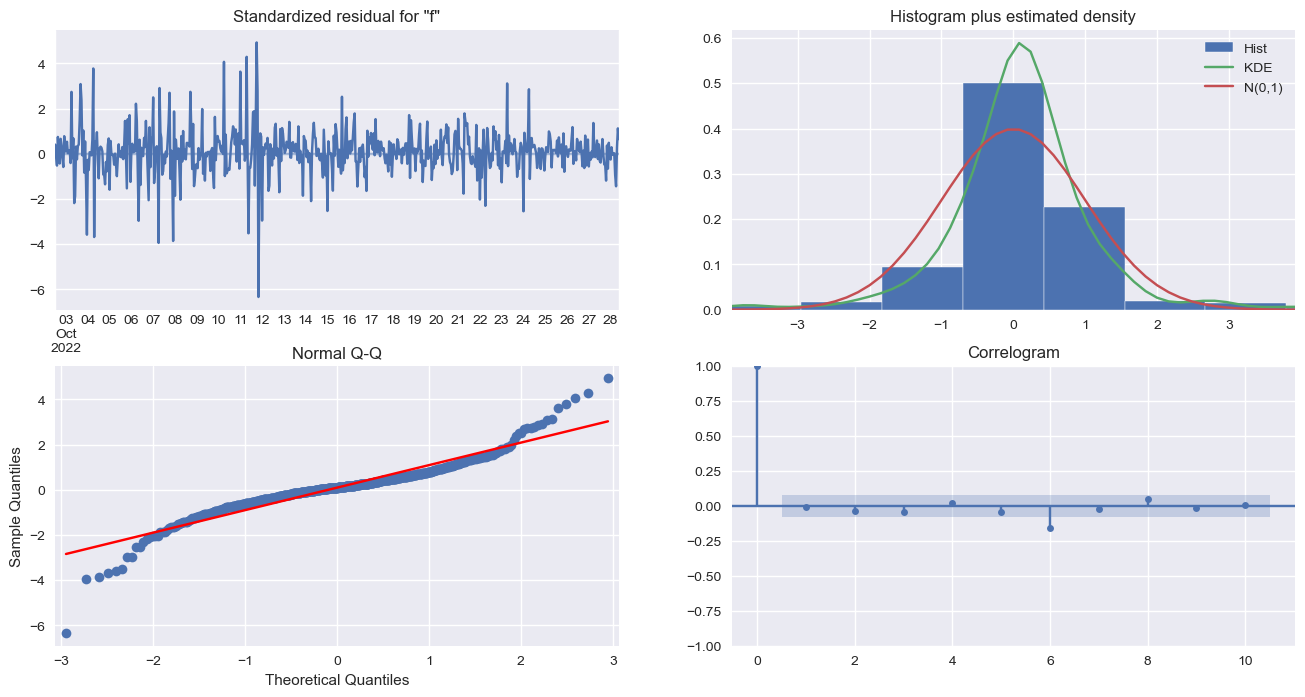

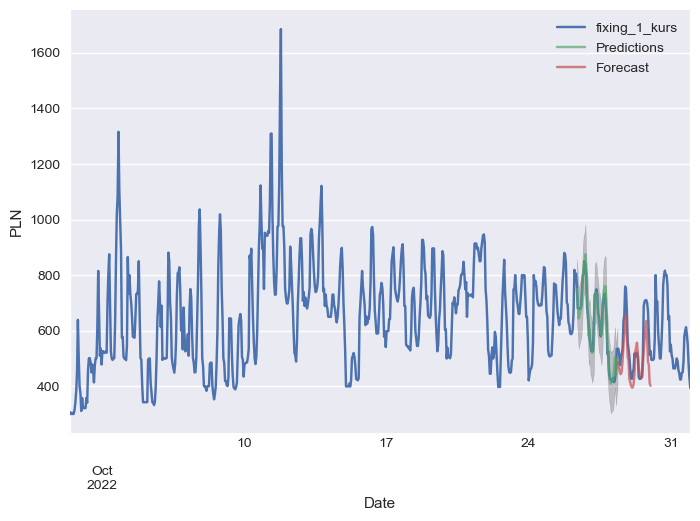

Test_range. mae: 22.7969, rmse: 29.838, nrmse: 0.0686
Forecast.   mae: 64.834, rmse: 77.9804, nrmse: 0.2347


In [180]:
params = {
    "order": (1, 0, 1),
    "seasonal_order": (1, 0, 1, 24),
    "chart": True
}   
results=create_model_sarimax(train, **params)
metrics, df_kurs = get_forecast(results,data,forecast,train_start_test,forecast_end_date,train_end_date)

## Validation

In [185]:
def decrease_date(date, count_day):
    return pd.to_datetime(date)-timedelta(days=count_day) 

def custom_validation(params,train_start_date,train_end_date,train_start_test,forecast_end_date,df_tge,chart,count_slice, step_day):
    initial_day=count_slice*step_day
    df_kurs=pd.DataFrame()
    list_metrics=[]
    for idx, day in enumerate( range(initial_day, 0, -step_day) ):
       
        train_start_date=decrease_date(train_start_date, day)  
        train_end_date=decrease_date(train_end_date, day) 
        train_start_test=decrease_date(train_start_test, day) 
        forecast_end_date=decrease_date(forecast_end_date, day) 
        print(f'train_start_date: {train_start_date}')
        print(f'forecast_end_date: {forecast_end_date}')
        data, train, forecast = get_df(df_tge,train_start_date,train_end_date,forecast_end_date)
        results=create_model_sarimax(train, **params)
        metrics, df = get_forecast(results,data,forecast,train_start_test,forecast_end_date,train_end_date,chart)
        list_metrics.append(metrics)
        df_kurs=pd.concat([df_kurs,df])
    return list_metrics, df_kurs, data, train, forecast

In [188]:
warnings.filterwarnings("ignore")
params = {
    "order": (1, 0, 1),
    "seasonal_order": (1, 0, 1, 24),
    "chart": False
}   
list_metrics, df_kurs, data1, train1, forecast1 = custom_validation(params,train_start_date,train_end_date,train_start_test,forecast_end_date,df_tge,chart=False,count_slice=10, step_day=5)

train_start_date: 2022-08-12 09:00:00
forecast_end_date: 2022-09-10 00:00:00
Test_range. mae: 167.7653, rmse: 207.199, nrmse: 0.4761
Forecast.   mae: 346.0694, rmse: 401.0393, nrmse: 0.4309
train_start_date: 2022-06-28 09:00:00
forecast_end_date: 2022-07-27 00:00:00
Test_range. mae: 452.8304, rmse: 608.3381, nrmse: 1.3978
Forecast.   mae: 120.5377, rmse: 140.5996, nrmse: 0.0857
train_start_date: 2022-05-19 09:00:00
forecast_end_date: 2022-06-17 00:00:00
Test_range. mae: 272.4255, rmse: 321.9904, nrmse: 0.7399
Forecast.   mae: 149.1251, rmse: 196.6313, nrmse: 0.1805
train_start_date: 2022-04-14 09:00:00
forecast_end_date: 2022-05-13 00:00:00
Test_range. mae: 117.4947, rmse: 139.2057, nrmse: 0.3199
Forecast.   mae: 67.3402, rmse: 77.8536, nrmse: 0.1425
train_start_date: 2022-03-15 09:00:00
forecast_end_date: 2022-04-13 00:00:00
Test_range. mae: 269.7478, rmse: 311.8674, nrmse: 0.7166
Forecast.   mae: 133.2922, rmse: 142.7687, nrmse: 0.2364
train_start_date: 2022-02-18 09:00:00
forecast_e

In [175]:
%%time
#sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)
sarimax_param = auto_arima(train, m=24, start_p=0, d=0, start_q=0, start_P=0, D=0, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=8614.676, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=7274.658, Time=1.83 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=7899.928, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=10297.767, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=7539.351, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=7235.427, Time=5.08 sec
 ARIMA(1,0,0)(3,0,0)[24] intercept   : AIC=inf, Time=16.20 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=7143.191, Time=3.06 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=7374.051, Time=1.20 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=8502.528, Time=1.53 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=7156.617, Time=3.47 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=7130.954, Time=3.27 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=7329.606, Time=1.81 sec
 ARIMA(1,0,1)(1,0,0)[24] in

In [168]:
warnings.filterwarnings("ignore")
train_start_date="2022-10-01 09:00:00"  
train_end_date="2022-10-28 09:00:00"
train_start_test="2022-10-26 09:00:00"
forecast_end_date="2022-10-30 00:00:00"
params = {
    "order": (1, 0, 1),
    "seasonal_order": (1, 0, 1, 24),
    "chart": False
}   
list_metrics, df_kurs, data1, train1, forecast1 = custom_validation(params,train_start_date,train_end_date,train_start_test,forecast_end_date,df_tge,count_slice=1, step_day=205)
df_kurs

train_start_date: 2022-03-10 09:00:00
forecast_end_date: 2022-04-08 00:00:00
Test_range. mae: 122.3104, rmse: 149.0833, nrmse: 0.3426
Forecast.   mae: 65.9131, rmse: 93.5053, nrmse: 0.1317


,date_hour,kurs_fact,kurs_predict,diff_perc
0,2022-04-06 10:00:00,420.53,412.338052,-1.95
1,2022-04-06 11:00:00,405.48,392.964730,-3.09
2,2022-04-06 12:00:00,403.18,378.709806,-6.07
3,2022-04-06 13:00:00,390.49,373.039324,-4.47
4,2022-04-06 14:00:00,390.49,371.519795,-4.86
5,2022-04-06 15:00:00,395.45,387.627826,-1.98
6,2022-04-06 16:00:00,404.90,400.993584,-0.96
7,2022-04-06 17:00:00,430.00,446.383094,3.81
8,2022-04-06 18:00:00,448.74,511.427111,13.97
9,2022-04-06 19:00:00,500.00,650.082861,30.02


In [169]:
df_tge.query('date>"2022-04-06"').head(24)

,date,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,date_hour
date_hour,,,,,,,,,
2022-04-07 00:00:00,2022-04-07,1,329.31,3775.8,325.18,749.3,0.0,0.0,2022-04-07 00:00:00
2022-04-07 01:00:00,2022-04-07,2,286.34,3859.1,286.62,673.2,0.0,0.0,2022-04-07 01:00:00
2022-04-07 02:00:00,2022-04-07,3,273.42,3936.9,252.77,778.8,0.0,0.0,2022-04-07 02:00:00
2022-04-07 03:00:00,2022-04-07,4,270.00,3974.5,246.38,688.9,0.0,0.0,2022-04-07 03:00:00
2022-04-07 04:00:00,2022-04-07,5,299.00,3429.7,268.77,1166.4,0.0,0.0,2022-04-07 04:00:00
2022-04-07 05:00:00,2022-04-07,6,350.00,3862.5,341.63,778.1,0.0,0.0,2022-04-07 05:00:00
2022-04-07 06:00:00,2022-04-07,7,425.00,3555.1,442.32,699.2,0.0,0.0,2022-04-07 06:00:00
2022-04-07 07:00:00,2022-04-07,8,432.24,3415.4,428.72,1344.5,0.0,0.0,2022-04-07 07:00:00
2022-04-07 08:00:00,2022-04-07,9,440.00,3414.5,444.62,1314.3,0.0,0.0,2022-04-07 08:00:00
